# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_Aging3_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for Aging3 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_Aging3_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [39]:
library(data.table)
library(tidyverse)
library(pecotmr)

In [40]:
setwd("~/data")

In [41]:
##Bonfferroni correction is too strict
# Aging3_twas = fread("~/project/image_QTL/twas/multiple_testing/image_Aging3_twas_bonff.bonf_corrected.tsv.gz")


In [42]:
Aging3_twas = fread("~/project/image_QTL/twas/image_Aging3_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [5]:
# weight_db_list = fread("~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv")


In [6]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- Aging3_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [7]:
head(Aging3_twas)
dim(Aging3_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging3,enet,TRUE,FALSE,0.098757440,8.923911e-10,0.9022919,0.3669019,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging3,lasso,TRUE,FALSE,0.103370596,3.541036e-10,0.8315505,0.4056627,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging3,mrash,TRUE,FALSE,0.089177838,6.013310e-09,1.0668278,0.2860496,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging3,susie,TRUE,TRUE,0.121638427,8.766557e-12,0.9338231,0.3503952,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging3,enet,TRUE,FALSE,0.007872702,5.201216e-02,-1.5674767,0.1170033,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging3,lasso,TRUE,FALSE,0.006195072,7.447581e-02,-1.5819370,0.1136639,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 924774     19

In [43]:
# Strong and reliable TWAS signals:
Aging3_twas_filtered <- Aging3_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
Aging3_block = unique(Aging3_twas_filtered$block)

In [44]:
dim(Aging3_twas_filtered)

[1] 181  19

In [45]:
most_likely_causal_genes = Aging3_twas_filtered |> 
  group_by(context, region) |> 
  slice_max(abs(twas_z), n = 1)

In [46]:
head(most_likely_causal_genes)
dim(most_likely_causal_genes)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000183605,119165713,117200000,122280000,AC_DeJager_eQTL,image_Aging3,bayes_l,TRUE,FALSE,0.02435672,7.996839e-05,-4.913459,8.948324e-07,eQTL,chr10_118977449_120143558,chr10_118977449_120143558,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr10_118977449_120143558.twas.tsv.gz
14,ENSG00000100578,58427384,56480000,60600000,AC_DeJager_eQTL,image_Aging3,enet,TRUE,FALSE,0.03901636,7.434663e-07,4.965977,6.835601e-07,eQTL,chr14_56126490_58669547,chr14_56126490_58669547,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr14_56126490_58669547.twas.tsv.gz
14,ENSG00000151838,59576811,58080000,60600000,AC_DeJager_eQTL,image_Aging3,lasso,TRUE,FALSE,0.05531967,4.042739e-09,-4.831920,1.352224e-06,eQTL,chr14_58669547_61213190,chr14_58669547_61213190,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr14_58669547_61213190.twas.tsv.gz
16,ENSG00000102882,30123505,28360000,34000000,AC_DeJager_eQTL,image_Aging3,bayes_l,TRUE,FALSE,0.01162174,4.940341e-03,-4.823815,1.408381e-06,eQTL,chr16_29685831_46381513,chr16_29685831_46381513,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr16_29685831_46381513.twas.tsv.gz
2,ENSG00000163171,37738467,36641882,39240000,AC_DeJager_eQTL,image_Aging3,bayes_l,TRUE,FALSE,0.06346084,2.940073e-10,4.715348,2.412974e-06,eQTL,chr2_37591842_40054824,chr2_37591842_40054824,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr2_37591842_40054824.twas.tsv.gz
2,ENSG00000115306,54456316,53456316,55680000,AC_DeJager_eQTL,image_Aging3,mvsusie,TRUE,TRUE,0.15515808,1.147919e-23,-6.795519,1.079235e-11,eQTL,chr2_53613086_54460117,chr2_53613086_54460117,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr2_53613086_54460117.twas.tsv.gz


[1] 70 19

In [47]:
most_likely_causal_genes |> count(molecular_id) |> nrow()

[1] 70

In [48]:
Aging3_gene = unique(most_likely_causal_genes$molecular_id)

In [49]:
image_Aging3_gene_list <- Aging3_twas |> 
  dplyr::filter(molecular_id %in% Aging3_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), molecular_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, molecular_id) |> 
  unique()

In [50]:
dim(image_Aging3_gene_list)

[1] 42  4

In [51]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [52]:
image_Aging3_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_Aging3")) |> dplyr::select(-strand,-event_ID)
                                        

In [53]:
image_Aging3_gene = bind_rows(image_Aging3_gene_list, image_Aging3_QTL_gene)

In [54]:
fwrite(image_Aging3_gene, "~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging3_gene_list.tsv", sep = '\t')

### image_Aging3_QTL list

In [55]:
image_Aging3_gene = fread("~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging3_gene_list.tsv")

In [56]:

library(clusterProfiler)
library(org.Hs.eg.db)


In [57]:
Aging3_sig_gene_ego <- enrichGO(
  gene          = unique(image_Aging3_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [58]:
head(Aging3_sig_gene_ego, n=10)
# Aging3_sig_gene_ego |> as.data.frame() %>% dplyr::slice(50:100)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0032872,GO:0032872,regulation of stress-activated MAPK cascade,7/39,208/21261,9.144223e-08,8.031163e-05,6.055147e-05,ENSG00000102882/ENSG00000112715/ENSG00000147324/ENSG00000169032/ENSG00000149930/ENSG00000078747/ENSG00000232810,7
GO:0070302,GO:0070302,regulation of stress-activated protein kinase signaling cascade,7/39,211/21261,1.008307e-07,8.031163e-05,6.055147e-05,ENSG00000102882/ENSG00000112715/ENSG00000147324/ENSG00000169032/ENSG00000149930/ENSG00000078747/ENSG00000232810,7
GO:0051403,GO:0051403,stress-activated MAPK cascade,7/39,260/21261,4.154773e-07,2.029056e-04,1.529820e-04,ENSG00000102882/ENSG00000112715/ENSG00000147324/ENSG00000169032/ENSG00000149930/ENSG00000078747/ENSG00000232810,7
GO:0031098,GO:0031098,stress-activated protein kinase signaling cascade,7/39,268/21261,5.094931e-07,2.029056e-04,1.529820e-04,ENSG00000102882/ENSG00000112715/ENSG00000147324/ENSG00000169032/ENSG00000149930/ENSG00000078747/ENSG00000232810,7
GO:0048708,GO:0048708,astrocyte differentiation,4/39,105/21261,4.044091e-05,1.288447e-02,9.714332e-03,ENSG00000102882/ENSG00000169032/ENSG00000136717/ENSG00000232810,4
GO:0032874,GO:0032874,positive regulation of stress-activated MAPK cascade,4/39,141/21261,1.273023e-04,2.584349e-02,1.948487e-02,ENSG00000112715/ENSG00000147324/ENSG00000149930/ENSG00000232810,4
GO:0050769,GO:0050769,positive regulation of neurogenesis,5/39,270/21261,1.287189e-04,2.584349e-02,1.948487e-02,ENSG00000187164/ENSG00000112715/ENSG00000169032/ENSG00000136717/ENSG00000232810,5
GO:0070304,GO:0070304,positive regulation of stress-activated protein kinase signaling cascade,4/39,143/21261,1.344078e-04,2.584349e-02,1.948487e-02,ENSG00000112715/ENSG00000147324/ENSG00000149930/ENSG00000232810,4
GO:0046328,GO:0046328,regulation of JNK cascade,4/39,153/21261,1.743196e-04,2.584349e-02,1.948487e-02,ENSG00000147324/ENSG00000149930/ENSG00000078747/ENSG00000232810,4


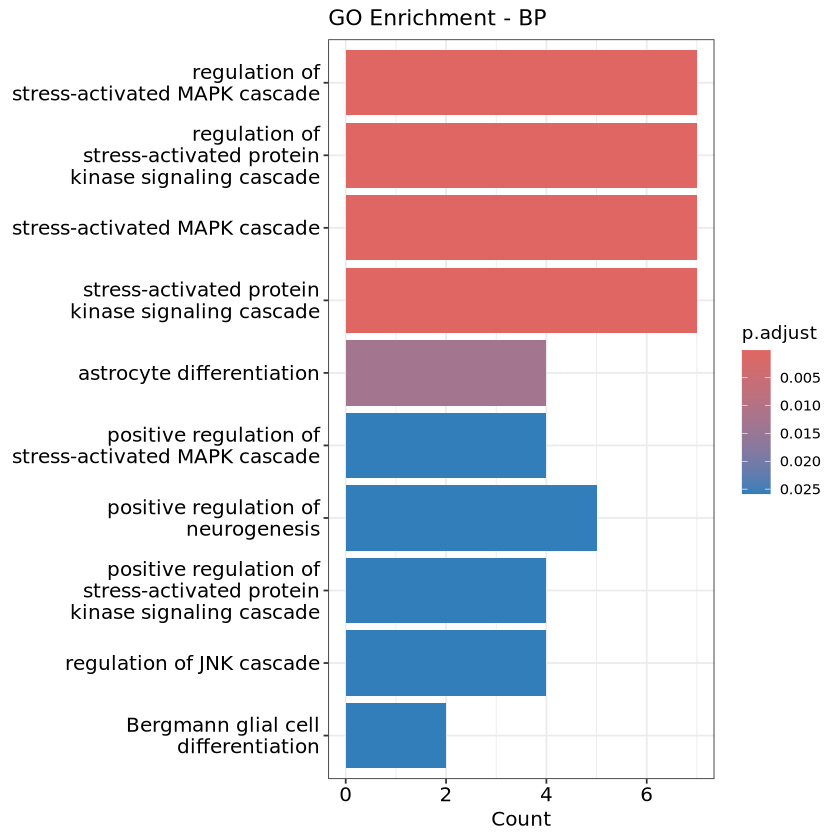

In [59]:
barplot(Aging3_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [60]:
Aging3_sig_gene_ego_cc <- enrichGO(
  gene          = unique(image_Aging3_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [61]:
head(Aging3_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0044295,GO:0044295,axonal growth cone,2/40,30/22568,0.001291242,0.1064968,0.09025155,ENSG00000187164/ENSG00000149930,2
GO:0150034,GO:0150034,distal axon,4/40,295/22568,0.001805031,0.1064968,0.09025155,ENSG00000187164/ENSG00000149930/ENSG00000082482/ENSG00000136717,4
GO:0044304,GO:0044304,main axon,2/40,81/22568,0.009085057,0.2292365,0.19426822,ENSG00000115306/ENSG00000136717,2
GO:0098850,GO:0098850,extrinsic component of synaptic vesicle membrane,1/40,11/22568,0.019329012,0.2292365,0.19426822,ENSG00000136717,1
GO:0043679,GO:0043679,axon terminus,2/40,122/22568,0.019774911,0.2292365,0.19426822,ENSG00000082482/ENSG00000136717,2
GO:0044294,GO:0044294,dendritic growth cone,1/40,12/22568,0.021068021,0.2292365,0.19426822,ENSG00000149930,1
GO:0044666,GO:0044666,MLL3/4 complex,1/40,12/22568,0.021068021,0.2292365,0.19426822,ENSG00000198646,1
GO:0044306,GO:0044306,neuron projection terminus,2/40,138/22568,0.024881342,0.2292365,0.19426822,ENSG00000082482/ENSG00000136717,2
GO:0090571,GO:0090571,RNA polymerase II transcription repressor complex,1/40,15/22568,0.026267029,0.2292365,0.19426822,ENSG00000136717,1


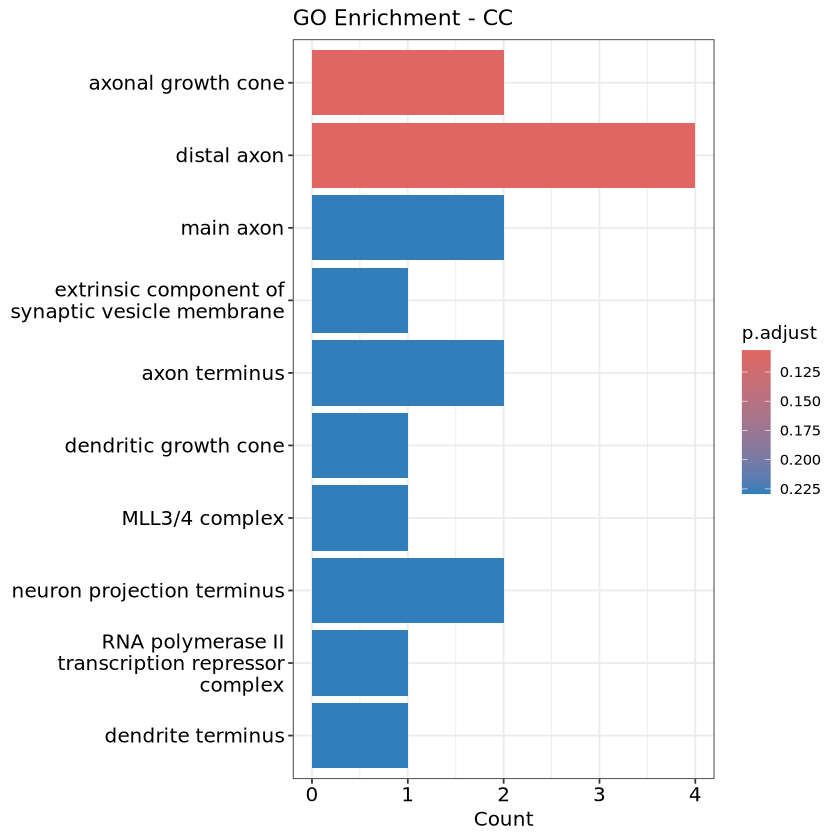

In [62]:
barplot(Aging3_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [63]:
image_Aging3_sig_gene_ego_mf <- enrichGO(
  gene          = unique(image_Aging3_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [64]:
head(image_Aging3_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004708,GO:0004708,MAP kinase kinase activity,2/39,18/21059,0.0005018188,0.06874917,0.05176657,ENSG00000102882/ENSG00000169032,2
GO:0030295,GO:0030295,protein kinase activator activity,3/39,133/21059,0.0019060390,0.10192668,0.07674848,ENSG00000112715/ENSG00000169032/ENSG00000149930,3
GO:0019209,GO:0019209,kinase activator activity,3/39,142/21059,0.0022966186,0.10192668,0.07674848,ENSG00000112715/ENSG00000169032/ENSG00000149930,3
GO:0048156,GO:0048156,tau protein binding,2/39,45/21059,0.0031462351,0.10192668,0.07674848,ENSG00000149930/ENSG00000136717,2
GO:0004712,GO:0004712,protein serine/threonine/tyrosine kinase activity,2/39,49/21059,0.0037199518,0.10192668,0.07674848,ENSG00000102882/ENSG00000169032,2
GO:0106310,GO:0106310,protein serine kinase activity,4/39,377/21059,0.0050715376,0.10469878,0.07883581,ENSG00000102882/ENSG00000028116/ENSG00000169032/ENSG00000149930,4
GO:0043539,GO:0043539,protein serine/threonine kinase activator activity,2/39,59/21059,0.0053495726,0.10469878,0.07883581,ENSG00000169032/ENSG00000149930,2
GO:0051015,GO:0051015,actin filament binding,3/39,225/21059,0.0082863392,0.14190356,0.10685016,ENSG00000187164/ENSG00000115306/ENSG00000136717,3
GO:0004674,GO:0004674,protein serine/threonine kinase activity,4/39,467/21059,0.0106372280,0.14944611,0.11252953,ENSG00000102882/ENSG00000028116/ENSG00000169032/ENSG00000149930,4


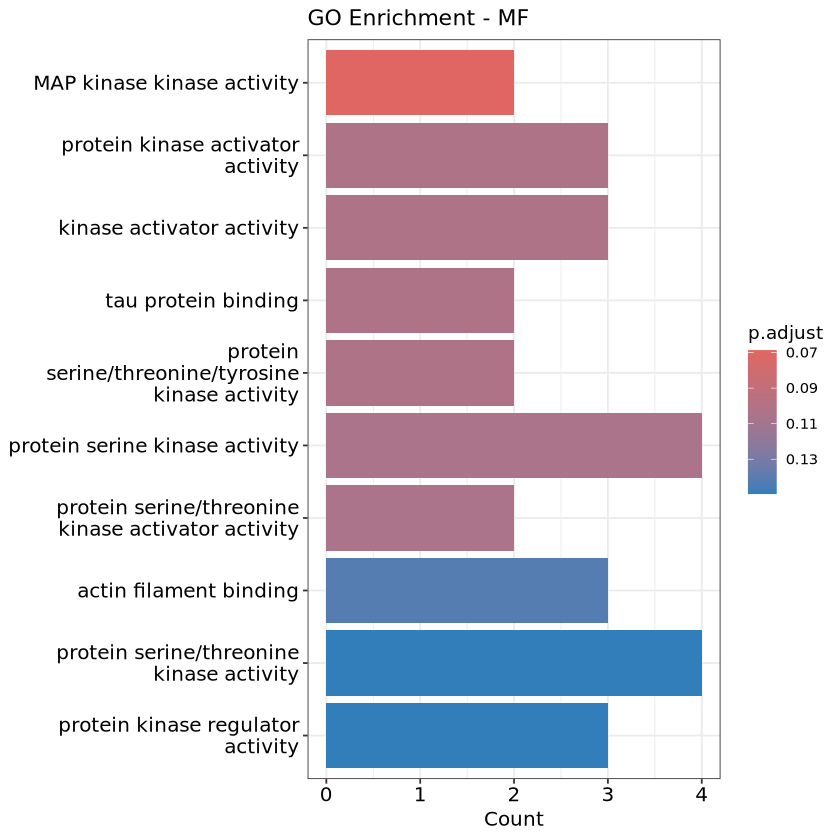

In [65]:
barplot(image_Aging3_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [66]:
entrez_ids <- bitr(image_Aging3_gene$molecular_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(image_Aging3_gene$molecular_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“2.33% of input gene IDs are fail to map...”


In [67]:
kegg_enrich %>% head(n=15)
# kegg_enrich |> as.data.frame() %>% dplyr::slice(50:70)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa05219,Human Diseases,Cancer: specific types,hsa05219,Bladder cancer,3/17,41/9446,4.948202e-05,0.004091844,0.001453351,5595/7422/5604,3
hsa04668,Environmental Information Processing,Signal transduction,hsa04668,TNF signaling pathway,4/17,119/9446,5.020668e-05,0.004091844,0.001453351,5595/5604/83737/7124,4
hsa04010,Environmental Information Processing,Signal transduction,hsa04010,MAPK signaling pathway,5/17,300/9446,1.412063e-04,0.006337432,0.002250944,5595/7422/5604/9344/7124,5
hsa04370,Environmental Information Processing,Signal transduction,hsa04370,VEGF signaling pathway,3/17,60/9446,1.555198e-04,0.006337432,0.002250944,5595/7422/5604,3
hsa04664,Organismal Systems,Immune system,hsa04664,Fc epsilon RI signaling pathway,3/17,69/9446,2.357416e-04,0.006683628,0.002373907,5595/5604/7124,3
hsa05211,Human Diseases,Cancer: specific types,hsa05211,Renal cell carcinoma,3/17,70/9446,2.460231e-04,0.006683628,0.002373907,5595/7422/5604,3
hsa05212,Human Diseases,Cancer: specific types,hsa05212,Pancreatic cancer,3/17,77/9446,3.262128e-04,0.007300668,0.002593069,5595/7422/5604,3
hsa01521,Human Diseases,Drug resistance: antineoplastic,hsa01521,EGFR tyrosine kinase inhibitor resistance,3/17,80/9446,3.651713e-04,0.007300668,0.002593069,5595/7422/5604,3
hsa05205,Human Diseases,Cancer: overview,hsa05205,Proteoglycans in cancer,4/17,204/9446,4.031044e-04,0.007300668,0.002593069,5595/7422/5604/7124,4


In [68]:
kegg_enrich %>% as.data.frame %>% filter(str_detect(Description, 'lipid|Lipid|fatty|Fatty|Alzheimer|Cholesterol|phagy'))


,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04071,Environmental Information Processing,Signal transduction,hsa04071,Sphingolipid signaling pathway,3/17,122/9446,0.001252278,0.01148863,0.004080561,5595/5604/7124,3
hsa05010,Human Diseases,Neurodegenerative disease,hsa05010,Alzheimer disease,4/17,391/9446,0.004479433,0.02212569,0.007858655,5595/5684/5604/7124,4
hsa04932,Human Diseases,Endocrine and metabolic disease,hsa04932,Non-alcoholic fatty liver disease,2/17,157/9446,0.031703488,0.05273131,0.018729236,83737/7124,2
hsa04140,Cellular Processes,Transport and catabolism,hsa04140,Autophagy - animal,2/17,169/9446,0.036291864,0.05857004,0.020803049,5595/5604,2
hsa05417,Human Diseases,Cardiovascular disease,hsa05417,Lipid and atherosclerosis,2/17,216/9446,0.056509927,0.08224213,0.029210959,5595/7124,2
hsa00565,Metabolism,Lipid metabolism,hsa00565,Ether lipid metabolism,1/17,51/9446,0.087996822,0.11567324,0.041085104,79153,1


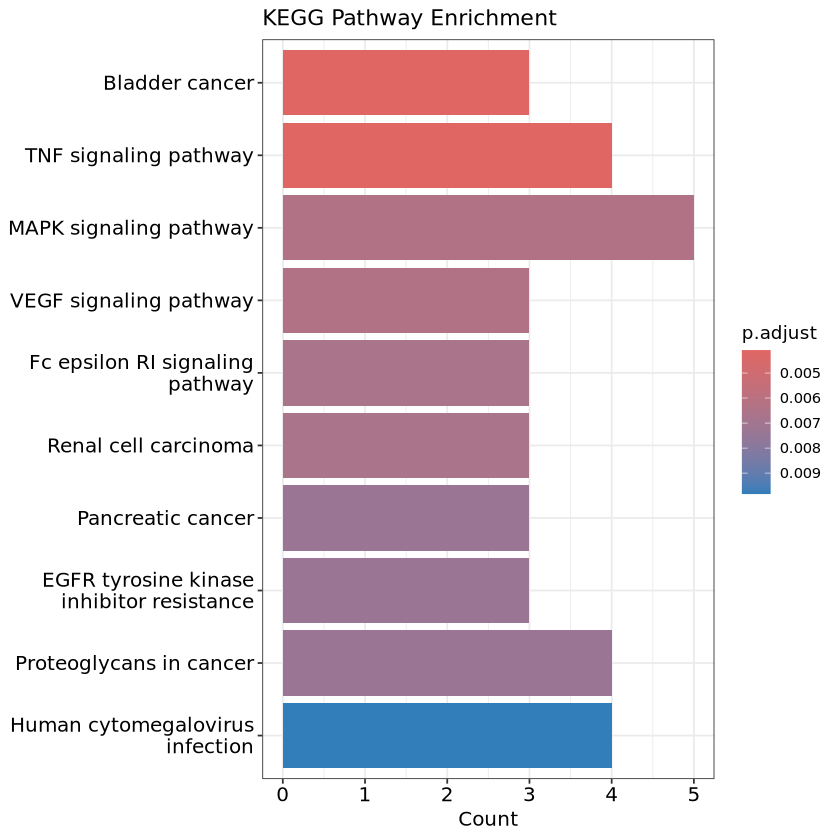

In [69]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")